<a href="https://colab.research.google.com/github/CaprioloSaggio/P300_Speller/blob/master/AY1920_DT_P300_SPELLER_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**P300 Speller - GROUP 2**

Fresco Andrea
Garza Roberto
Giove Morena
Losa Letizia
Molinari Giulia

# **Preprocessing**

## Import required modules ##
We import some modules in our script in order to provide us useful functions for the dataset analysis.

In [ ]:
import matplotlib.pyplot as plt   # Required to plot data
import numpy as np                # Management of arrays
import os                         # System utils
from scipy.io import loadmat, savemat     # Required to load and save .mat files
from scipy import signal          # Required for signal processing

%matplotlib inline

## Load data from Google Drive folder ##
We import the Google Drive module and mount our folder. 

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


We specify the paths to the location where our data are stored.

In [ ]:
# Setting data paths
CHANNEL_LOCATIONS_FILE_PATH = 'drive/My Drive/Data/channels.csv'
SUBJECT_A_TRAIN_FILE_PATH = 'drive/My Drive/Data/Subject_A_Train.mat'
SUBJECT_B_TRAIN_FILE_PATH = 'drive/My Drive/Data/Subject_B_Train.mat'
SUBJECT_A_TEST_FILE_PATH = 'drive/My Drive/Data/Subject_A_Test.mat'
SUBJECT_B_TEST_FILE_PATH = 'drive/My Drive/Data/Subject_B_Test.mat'

## Read Channel Locations File ##
We read the *channels.csv* file - that contains a list of all the channels that were used for the recording - and store the channels description strings in a list. 


In [ ]:
if not os.path.exists(CHANNEL_LOCATIONS_FILE_PATH):
    print("Missing file: {}", CHANNEL_LOCATIONS_FILE_PATH)
else:
  CHANNELS = [] 
  # Read file content
  with open(CHANNEL_LOCATIONS_FILE_PATH, "r") as f:
    file_content = f.read()
    # Loop over all rows (except first one)
    for row in file_content.split("\n")[1:]: 
      # Skip missing rows
      if row == '':
        continue
      CHANNELS.append(row)

We set the repetitions number and the frequency at which the EEG signal is sampled according to the dataset description (BCI competition III)

In [ ]:
# From the dataset description we know there are 15 repetitions
REPETITIONS = 15
# Data are sampled at 240 Hz
SAMPLING_FREQUENCY = 240  

## Read Data File ##
We define the **load_mydata** function to load the *.mat* files that store all the data we need to analyze. The variables of interest are:
- *Signal* containing the EEG signals from all the channels
- *Flashing* containing the flashing sequence (1 means column/row intensified, 0 means no intensification)
- *TargetChar* containing the word (letter) that the subject spelled during the recording
- *StimulusCode* containing the intensified column/row index (1...6 for columns, 7...12 for rows, 0 for no intensification)
- *StimulusType* containing the P300-noP300 sequence (1 means that the intensified column/row contains the target char, 0 otherwise)

We also extract some explicative variables: recording duration, number of trials and number of samples for each trial


In [ ]:
def load_mydata(file_path):
  
  if not os.path.exists(file_path):
      print("Missing file: {}", file_path)
  else:
    # Load the required data
    data = loadmat(file_path)
    # Get the variables of interest from the loaded dictionary
    signals = data['Signal']
    flashing = data['Flashing']
    word = data['TargetChar']
    stimulusCode = data['StimulusCode'] 
    # Since StimulusType is available in training datasets only
    key = data.keys() 
    if "StimulusType" in key: 
      stimulusType = data['StimulusType']
    else:
      stimulusType = ""  
    # We've just loaded 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'

    # Compute the duration of the recording in minutes
    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS = len(word[0])
    # Compute number of samples per trial
    SAMPLES_PER_TRIAL = len(signals[0])

    print("**********************************")
    print("        DATASET INFORMATION       ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, 
        (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % word)
    print("File:               %s" % file_path.split("/")[-1])
    print()
    return signals, flashing, word, stimulusType, stimulusCode

In [ ]:
# We load the data
signal_A_TRAIN, flashing_A_TRAIN, word_A_TRAIN, stimulusType_A_TRAIN, _ = load_mydata(SUBJECT_A_TRAIN_FILE_PATH)
signal_B_TRAIN, flashing_B_TRAIN, word_B_TRAIN, stimulusType_B_TRAIN, _ = load_mydata(SUBJECT_B_TRAIN_FILE_PATH)
signal_A_TEST, flashing_A_TEST, word_A_TEST, _, stimulusCode_A = load_mydata(SUBJECT_A_TEST_FILE_PATH)
signal_B_TEST, flashing_B_TEST, word_B_TEST, _, stimulusCode_B = load_mydata(SUBJECT_B_TEST_FILE_PATH)

**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01
Number of letters:  85
Spelled word:       ['EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI']
File:               Subject_A_Train.mat

**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01
Number of letters:  85
Spelled word:       ['VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO']
File:               Subject_B_Train.mat

**********************************
        DATASET INFORMATION       
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12
Number of letters:  100
Spelled word:       ['WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU']

## Filter design ##
We define Butterworth filter parameters according to *Carabez et al. 2017* and plot its frequency response 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


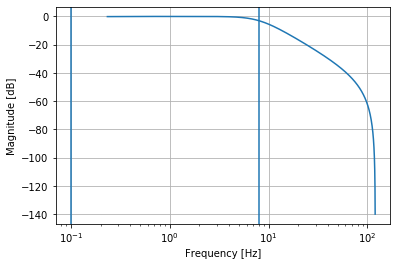

In [ ]:
# 2nd order bandpass Butterworth with cutting frequencies of 0.1 Hz and 8 Hz
b,a = signal.butter(2, [0.1/(SAMPLING_FREQUENCY/2), 8/(SAMPLING_FREQUENCY/2)], 'bandpass')
# Frequency response
f,h = signal.freqz(b,a, fs = SAMPLING_FREQUENCY)

# Semilog plot
plt.semilogx(f, 20 * np.log10(abs(h))) 
plt.axvline(x=0.1) # f_cut1 [Hz]
plt.axvline(x=8) # f_cut2 [Hz]
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

# **Subtask 1**

We define **filter_mysignal** function, that first extracts the epochs from signal and then applies the filter. According to *Carabez et al. 2017* we also use the Savitzky-Golay filter. Finally we distinguish the P300 from the non-P300 epochs.

In [ ]:
def filter_mysignal(sig, flash, stim_type, dataset='train'):
  
  TRIALS = len(sig[:,1,1]) # Number of the letters
  SAMPLES_PER_TRIAL = len(sig[1,:,1])

  epochs = []           # Init 3D array to store EEG epochs
  epoch_labels = []     # Init array to store epoch labels
  epochDuration = int(SAMPLING_FREQUENCY)  # Duration of the epoch is 1000 ms -> 240 samples
  y_target = []
  epochs_P300 = []
  epochs_noP300 = []

  # Savitzky-Golay
  window_length = 5 
  polyorder = 2 
  
  # For loop over all the trials
  for trial in range(TRIALS):
    for sample in range(SAMPLES_PER_TRIAL):
    # Check if flashing changed from 0 or 1 or if it's the first sample (always 1)
      if ( sample == 0 or (flash[trial, sample-1] == 0 and flash[trial, sample] == 1)):
        
      # Extract an epoch
        lower_sample = sample
        upper_sample = sample + epochDuration
        
      # Apply the filters
        epoch = sig[trial, int(lower_sample):int(upper_sample), :]
        epoch = signal.savgol_filter(epoch, window_length, polyorder, axis=0)
        epoch = signal.filtfilt(b, a, epoch, axis = 0)
        epoch = signal.decimate(epoch, 10, axis=0) # downsampling 10 times lower
        
      # Normalize each epoch
        epoch = (epoch - np.mean(epoch, axis=0, keepdims=True)) / np.std(epoch, axis=0, keepdims=True)
        epochs.append(epoch)

      # Distinguish P300 and non-P300 epochs
        if dataset == 'train':
          if stim_type[trial, sample] == 1:
            epochs_P300.append(epoch)
            y_target.append(1)
          elif stim_type[trial, sample] == 0:
            epochs_noP300.append(epoch)
            y_target.append(0)
          else: print('Error in finding a class for the {}-th letter'.format(trial))

# Return filtered epochs from raw signal, target type (P300: 1, non-P300: 0), P300 epochs and non-P300 epochs    
  return np.array(epochs), np.array(y_target).reshape(len(y_target),1), np.array(epochs_P300), np.array(epochs_noP300) 

Now we filter the signals

In [ ]:
# Filter the signals
print('Filtering signal 1...')
epochs_A_TRAIN, target_A_TRAIN, epochs_A_TRAIN_P300, epochs_A_TRAIN_noP300 = filter_mysignal(signal_A_TRAIN, flashing_A_TRAIN, stimulusType_A_TRAIN)
print('Filtering signal 2...')
epochs_B_TRAIN, target_B_TRAIN, epochs_B_TRAIN_P300, epochs_B_TRAIN_noP300 = filter_mysignal(signal_B_TRAIN, flashing_B_TRAIN, stimulusType_B_TRAIN)
print('Filtering signal 3...')
epochs_A_TEST, _, epochs_A_TEST_P300, epochs_A_TEST_noP300 =  filter_mysignal(signal_A_TEST, flashing_A_TEST, _, dataset='test')
print('Filtering signal 4...')
epochs_B_TEST, _, epochs_B_TEST_P300, epochs_B_TEST_noP300 = filter_mysignal(signal_B_TEST, flashing_B_TEST, _, dataset='test')

Filtering signal 1...
Filtering signal 2...
Filtering signal 3...
Filtering signal 4...


We define **matrixchannel** function, reshaping electrodes according to *Carabez et al. 2017*, since their study was on an auditory dataset, we adjust the position of T9 and T10 for visual stimuli 

In [ ]:
def matrixchannel(epoch):

  m = np.zeros((len(epoch[:,0,0]),len(epoch[0,:,0]),10,11))
  
  m[:,:,0,4:7]=epoch[:,:,21:24] #from Fp1 to Fp2
  m[:,:,1,3:8]=epoch[:,:,24:29] #from Af7 to Af8
  m[:,:,2,1:10]=epoch[:,:,29:38] #from F7 to F8
  m[:,:,3,1]=epoch[:,:,38] #Ft7
  m[:,:,3,2:9]=epoch[:,:,0:7] #from FC5 to FC6 
  m[:,:,3,9]=epoch[:,:,39] #Ft8
  m[:,:,4,1]=epoch[:,:,40] #T7
  m[:,:,4,2:9]=epoch[:,:,7:14] #from C5 to C6
  m[:,:,4,9]=epoch[:,:,41] #T8
  m[:,:,5,1]=epoch[:,:,44] #Tp7
  m[:,:,5,2:9]=epoch[:,:,14:21] #from Cp5 to Cp6
  m[:,:,5,9]=epoch[:,:,45] #Tp8
  m[:,:,4,0]=epoch[:,:,42] #P9 (auditory) T9 (visual)
  m[:,:,6,1:10]=epoch[:,:,46:55] #from P7 to P8 
  m[:,:,4,10]=epoch[:,:,43] #P10 (auditory) T10 (visual)
  m[:,:,7,3:8]=epoch[:,:,55:60] #from PO7 to PO8
  m[:,:,8,4:7]=epoch[:,:,60:63] #from O1 to O2 
  m[:,:,9,5]=epoch[:,:,63] #Iz 

  return m # m is a 10-by-11 matrix containing the epochs corresponding to each electrode

We apply the function to all the pre-processed signals

In [ ]:
epochs_A_TRAIN_reshaped = matrixchannel(epochs_A_TRAIN)
epochs_A_TEST_reshaped = matrixchannel(epochs_A_TEST)
epochs_B_TRAIN_reshaped = matrixchannel(epochs_B_TRAIN)
epochs_B_TEST_reshaped = matrixchannel(epochs_B_TEST)

epochs_A_TRAIN_P300 = matrixchannel(epochs_A_TRAIN_P300)
epochs_A_TRAIN_noP300 = matrixchannel(epochs_A_TRAIN_noP300)

print(epochs_A_TRAIN_reshaped.shape) # print the dimensions obtained

(15300, 24, 10, 11)


In the next 2 cells we plot respectively temporal development of one P300 epoch and of a non-P300 epoch. The P300 wave should appear at 300ms, in correspondence of the 8th sample



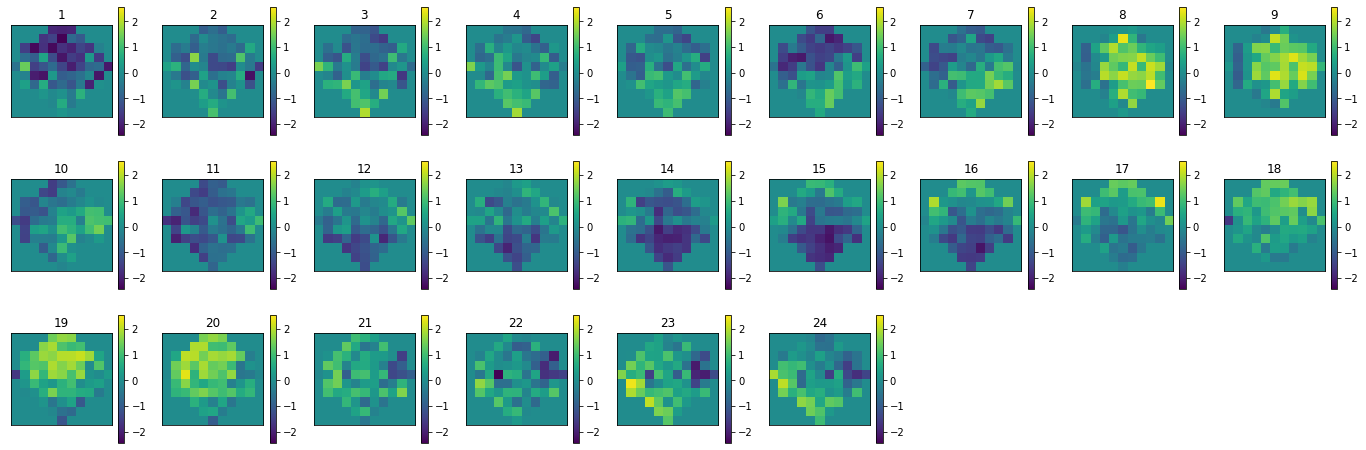

In [ ]:
num=10 # select the 11th epoch as a random demonstrative example
maxi=epochs_A_TRAIN_P300[num,:].ravel().max() # For the plotting range
mini=epochs_A_TRAIN_P300[num,:].ravel().min() # For the plotting range

plt.figure(figsize=(24,25))
for i in range(24):
  plt.subplot(9,9,i+1)
  plt.imshow(epochs_A_TRAIN_P300[num,i],  vmin=mini, vmax=maxi) 
  plt.title(str(i+1))
  plt.colorbar()
  plt.xticks([])
  plt.yticks([])

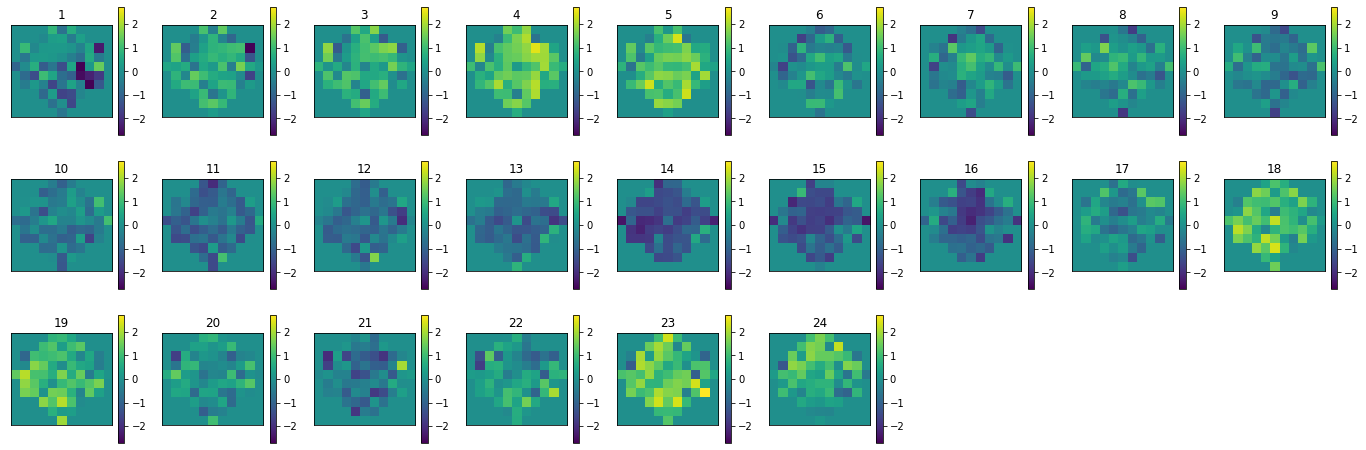

In [ ]:
num=10 # select the 11th epoch as a random demonstrative example
maxi=epochs_A_TRAIN_noP300[num,:].ravel().max()
mini=epochs_A_TRAIN_noP300[num,:].ravel().min()

plt.figure(figsize=(24,25))
for i in range(24):
  plt.subplot(9,9,i+1)
  plt.imshow(epochs_A_TRAIN_noP300[num,i],  vmin=mini, vmax=maxi)
  plt.title(str(i+1))
  plt.colorbar()
  plt.xticks([])
  plt.yticks([])

# **Subtask 2**

## Data preparation

We add a dummy dimension for the 3D convolution's sake

In [ ]:
epochs_A_TRAIN_reshaped = np.expand_dims(epochs_A_TRAIN_reshaped, axis=4)
epochs_A_TEST_reshaped = np.expand_dims(epochs_A_TEST_reshaped, axis=4)
epochs_B_TRAIN_reshaped = np.expand_dims(epochs_B_TRAIN_reshaped, axis=4)
epochs_B_TEST_reshaped = np.expand_dims(epochs_B_TEST_reshaped, axis=4)

print(epochs_A_TRAIN_reshaped.shape)
print(epochs_A_TEST_reshaped.shape)
print(epochs_B_TRAIN_reshaped.shape)
print(epochs_B_TEST_reshaped.shape)

(15300, 24, 10, 11, 1)
(18000, 24, 10, 11, 1)
(15300, 24, 10, 11, 1)
(18000, 24, 10, 11, 1)


We define **stimCode_reduced** function remove redundancy from stimulusCode array

In [ ]:
def stimCode_reduced(stimCode):
  newStimCode = []
  for i in range(len(stimCode[:,0])): # iterate for all the trials (letters) in the subject session
    index = np.where(np.diff(stimCode[i]) == 0) # find indeces where stimulus' codes repeat in the same trial (finding one letter) (1,1,1,1,1,0,0,0,0,7,7,7,7,0,0,0,0,12,12,12,12,0,0,0,0,...)
    newTemp_stimcode = np.delete(stimCode[i], index) # delete multiple sequence of the same number, keeping only the stimulus's codes interleaved by a zero (1, 0, 7, 0, 12, 0, ...)
    index = np.where(newTemp_stimcode == 0) # find indeces where zeros are
    newTemp_stimcode = np.delete(newTemp_stimcode, index) # delete zeros in the sequence (1, 7, 12, ...)
    newStimCode.append(newTemp_stimcode) # storing the reduced stimulus' code for each trials

  return np.array(newStimCode) # returning the session stimulus'code


We reduce the dimensions of StimulusCode for each subject applying the function

In [ ]:
stimCode_A_reduced = stimCode_reduced(stimulusCode_A)
stimCode_B_reduced = stimCode_reduced(stimulusCode_B)

Replicate the grid used in the experimental protocol

In [ ]:
MA=[['A','B','C','D','E','F'],
    ['G','H','I','J','K','L'],
    ['M','N','O','P','Q','R'],
    ['S','T','U','V','W','X'],
    ['Y','Z','1','2','3','4'],
    ['5','6','7','8','9','_']]

temp_MA = np.array(MA)

We define **target_test** function, that creates the surrogate of StimulusType for the test set. 

In [ ]:
def target_test(stimCode, wordTEST):
  # stimCode is used in its reduced version
  target_TEST = []
 
  for k in range(len(wordTEST)): # for every line/letter in the test set 
    i = np.where(temp_MA == wordTEST[k])[0][0] + 7 
    j = np.where(temp_MA == wordTEST[k])[1][0] + 1
    for sample in range(180): # every time I find a number of columns in stimulusCode corresponding to the letter spelled by the subject
      if (stimCode[k,sample] == i or stimCode[k,sample] == j): # check if the column or the row is the target one
        target_TEST.append(1)
      else:
        target_TEST.append(0)

  return np.array(target_TEST)


We apply the function and check the effectiveness

In [ ]:
target_A_TEST = target_test(stimCode_A_reduced, list(word_A_TEST[0]))
target_B_TEST = target_test(stimCode_B_reduced, list(word_B_TEST[0]))

print(target_A_TEST.shape)
print(target_B_TEST.shape)
print(np.unique(target_A_TEST))

(18000,)
(18000,)
[0 1]


## Network design

The following 3 cells use a Randomized Grid Search, thus performing hyperparameter tuning. They are commented out because they represent the most time-consuming part of the code. We perform them 3 times zooming each time in the neighbourhood of the best local results. The output of such operations are used in the model design   

In [ ]:
'''
def build_model_conv(n_hidden=1, n_neurons=72, conv_patch=(1,3,3), pool_patch=(1,2,2), pool_stride=(1,1,1), conv_layer_extra = False, input_shape=[24, 10, 11, 1],
                     activ = 'relu', drop_rate=0.5):
  model = keras.models.Sequential()
  
  model.add(keras.layers.Conv3D(filters=32, kernel_size = conv_patch, activation = activ, padding="SAME", input_shape=input_shape), kernel_regularizer= keras.regularizers.l2(l=0.02)) # adding the 3D convolutional layer
  
  if  conv_layer_extra: # adding optional 3D convolutional layer
    model.add(keras.layers.Conv3D(filters=64, kernel_size = conv_patch, strides=(1,2,2), activation = activ, padding="SAME"), kernel_regularizer= keras.regularizers.l2(l=0.02))
  
  model.add(keras.layers.MaxPool3D(pool_size=pool_patch, strides=pool_stride)) # adding MaxPool 3D layer

  model.add(keras.layers.Flatten()) # flattening the layers

  for layer in range(n_hidden): # adding as many as layers specified
    model.add(keras.layers.Dense(units=n_neurons, activation = activ), kernel_regularizer= keras.regularizers.l2(l=0.02))
    model.add(keras.layers.Dropout(drop_rate))
  
  model.add(keras.layers.Dense(units=1, activation="sigmoid"), kernel_regularizer= keras.regularizers.l2(l=0.02)) # adding last layer, convolution or non convolution
  
  optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9) # RMS prop as optimizer
  model.compile(loss="binary_crossentropy", optimizer=optimizer,  metrics=['accuracy'])
  return model
'''

'\ndef build_model_conv(n_hidden=1, n_neurons=72, conv_patch=(1,3,3), pool_patch=(1,2,2), pool_stride=(1,1,1), conv_layer_extra = False, input_shape=[24, 10, 11, 1],\n                     activ = \'relu\', drop_rate=0.5):\n  model = keras.models.Sequential()\n  \n  model.add(keras.layers.Conv3D(filters=32, kernel_size = conv_patch, activation = activ, padding="SAME", input_shape=input_shape), kernel_regularizer= keras.regularizers.l2(l=0.02)) # adding the 3D convolutional layer\n  \n  if  conv_layer_extra: # adding optional 3D convolutional layer\n    model.add(keras.layers.Conv3D(filters=64, kernel_size = conv_patch, strides=(1,2,2), activation = activ, padding="SAME"), kernel_regularizer= keras.regularizers.l2(l=0.02))\n  \n  model.add(keras.layers.MaxPool3D(pool_size=pool_patch, strides=pool_stride)) # adding MaxPool 3D layer\n\n  model.add(keras.layers.Flatten()) # flattening the layers\n\n  for layer in range(n_hidden): # adding as many as layers specified\n    model.add(keras.lay

In [ ]:
'''
keras_class_conv = keras.wrappers.scikit_learn.KerasClassifier(build_model_conv)
'''

'\nkeras_class_conv = keras.wrappers.scikit_learn.KerasClassifier(build_model_conv)\n'

In [ ]:
'''
from sklearn.model_selection import RandomizedSearchCV
param_distribs_conv ={

    "n_hidden": [1, 2], # (Shan et al., 2018)
    "n_neurons": np.arange(1,128), # (Shan et al., 2018)
    "conv_layer_extra": [True, False],
    "activ": 'elu', 'relu', 'selu', 'tanh',
    "drop_rate": np.random.uniform(0.2, 0.8, 100), # (Liu et al. 2017)
    "conv_patch": [(4,3,3), (4,2,2), (4,3,2), (4,2,3), (4,2,4), (4,1,4)], # (Carabez et al., 2017)
    "pool_patch": [(1,2,2), (1,3,3), (1,1,2), (1,1,3), (1,2,3)], # (Carabez et al., 2017)
    "pool_stride": [(1,1,1), (1,1,2), (1,1,3), (1,2,2), (1,2,3)] # (Carabez et al., 2017)

}

rand_search_cv = RandomizedSearchCV(keras_class_conv, param_distribs_conv, cv=3, n_iter=10)
rand_search_cv.fit(epochs_A_TRAIN_reshaped, target_A_TRAIN, epochs=5, 
                   validation_data = (epochs_A_TEST_reshaped,target_A_TEST), callbacks = [keras.callbacks.EarlyStopping(patience=10)],
                   verbose=1, batch_size=64)
'''

'\nfrom sklearn.model_selection import RandomizedSearchCV\nparam_distribs_conv ={\n\n    "n_hidden": [1, 2], # (Shan et al., 2018)\n    "n_neurons": np.arange(1,128), # (Shan et al., 2018)\n    "conv_layer_extra": [True, False],\n    "activ": \'elu\', \'relu\', \'selu\', \'tanh\',\n    "drop_rate": np.random.uniform(0.2, 0.8, 100), # (Liu et al. 2017)\n    "conv_patch": [(4,3,3), (4,2,2), (4,3,2), (4,2,3), (4,2,4), (4,1,4)], # (Carabez et al., 2017)\n    "pool_patch": [(1,2,2), (1,3,3), (1,1,2), (1,1,3), (1,2,3)], # (Carabez et al., 2017)\n    "pool_stride": [(1,1,1), (1,1,2), (1,1,3), (1,2,2), (1,2,3)] # (Carabez et al., 2017)\n\n}\n\nrand_search_cv = RandomizedSearchCV(keras_class_conv, param_distribs_conv, cv=3, n_iter=10)\nrand_search_cv.fit(epochs_A_TRAIN_reshaped, target_A_TRAIN, epochs=5, \n                   validation_data = (epochs_A_TEST_reshaped,target_A_TEST), callbacks = [keras.callbacks.EarlyStopping(patience=10)],\n                   verbose=1, batch_size=64)\n'

In [ ]:
'''
print("***********Best model***********")
print("Hidden units: {}".format(rnd_search_cv.best_params_['n_hidden']))
print("Neurons per unit: {}".format(rnd_search_cv.best_params_['n_neurons']))
print("Convolution Patch (kernel size): {}".format(rand_search_cv.best_params_['conv_patch']))
print("Pooling patch (pooling size): {}".format(rand_search_cv.best_params_['pool_patch']))
print("Pooling strides: {}".format(rand_search_cv.best_params_['pool_stride']))
print("Drop-out rate: {}".format(rand_search_cv.best_params_['drop_rate']))
print("Extra 3D convolutional layer: {}".format(rand_search_cv.best_params_['conv_layer_extra']))

print()
print("Best score (accuracy): {}".format(grid_search_cv.best_score_))
'''

'\nprint("***********Best model***********")\nprint("Hidden units: {}".format(rnd_search_cv.best_params_[\'n_hidden\']))\nprint("Neurons per unit: {}".format(rnd_search_cv.best_params_[\'n_neurons\']))\nprint("Convolution Patch (kernel size): {}".format(rand_search_cv.best_params_[\'conv_patch\']))\nprint("Pooling patch (pooling size): {}".format(rand_search_cv.best_params_[\'pool_patch\']))\nprint("Pooling strides: {}".format(rand_search_cv.best_params_[\'pool_stride\']))\nprint("Drop-out rate: {}".format(rand_search_cv.best_params_[\'drop_rate\']))\nprint("Extra 3D convolutional layer: {}".format(rand_search_cv.best_params_[\'conv_layer_extra\']))\n\nprint()\nprint("Best score (accuracy): {}".format(grid_search_cv.best_score_))\n'

Create the model

We now use the hyperparameters found as an output of Randomized Grid Search

In [ ]:
# MODEL A
from tensorflow import keras

modelA = keras.models.Sequential([
        keras.layers.Conv3D(filters=32, input_shape=[24, 10, 11, 1], kernel_size = [4,2,2], strides=(2,1,1),activation = 'elu', padding="SAME", 
                            kernel_regularizer= keras.regularizers.l2(l=0.02)),
    
        keras.layers.Conv3D(filters=64, kernel_size = [2,2,2], strides=(2,1,1),activation = 'elu', padding="SAME",
                            kernel_regularizer= keras.regularizers.l2(l=0.02)),

        keras.layers.MaxPool3D(pool_size=(1,2,2)), # Pool stride is the default one (1,1,1)

        keras.layers.Flatten(),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(units=1, activation='sigmoid')                                 
])

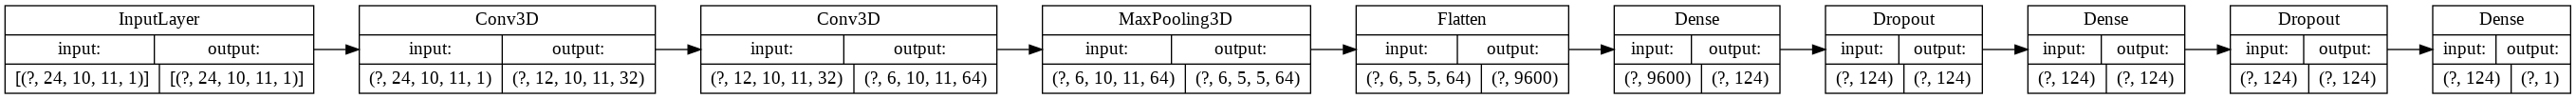

In [ ]:
keras.utils.plot_model( # Show model architecture
    modelA,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=False,
    rankdir='LR', # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
    dpi=96
)

Compile the model

In [ ]:
modelA.compile(loss='binary_crossentropy', 
               optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9), 
               metrics=['accuracy'])

In [ ]:
class_weight = {0: 1.,
                1: 5.}

In [ ]:
historyA = modelA.fit(epochs_A_TRAIN_reshaped, target_A_TRAIN, epochs=15, batch_size=32, class_weight=class_weight,
                    validation_data =(epochs_A_TEST_reshaped,target_A_TEST))

Train on 15300 samples, validate on 18000 samples
Epoch 1/15
15300/15300 [==============================] - 6s 420us/sample - loss: 2.1166 - acc: 0.5735 - val_loss: 0.8836 - val_acc: 0.4541
Epoch 2/15
15300/15300 [==============================] - 5s 335us/sample - loss: 1.1894 - acc: 0.6001 - val_loss: 0.7102 - val_acc: 0.6398
Epoch 3/15
15300/15300 [==============================] - 5s 337us/sample - loss: 1.1817 - acc: 0.6192 - val_loss: 0.8592 - val_acc: 0.5767
Epoch 4/15
15300/15300 [==============================] - 5s 337us/sample - loss: 1.1759 - acc: 0.6168 - val_loss: 0.7540 - val_acc: 0.6019
Epoch 5/15
15300/15300 [==============================] - 5s 337us/sample - loss: 1.1696 - acc: 0.6218 - val_loss: 0.6768 - val_acc: 0.8334
Epoch 6/15
15300/15300 [==============================] - 5s 336us/sample - loss: 1.1690 - acc: 0.6365 - val_loss: 0.7290 - val_acc: 0.6383
Epoch 7/15
15300/15300 [==============================] - 5s 337us/sample - loss: 1.1663 - acc: 0.6238 - val_l

Model B

In [ ]:
# MODEL B
from tensorflow import keras

modelB = keras.models.Sequential([
        keras.layers.Conv3D(filters=32, input_shape=[24, 10, 11, 1], kernel_size = [4,2,2], strides=(2,1,1),activation = 'elu', padding="SAME", 
                            kernel_regularizer= keras.regularizers.l2(l=0.02)),
    
        keras.layers.Conv3D(filters=64, kernel_size = [2,2,2], strides=(2,1,1),activation = 'elu', padding="SAME",
                            kernel_regularizer= keras.regularizers.l2(l=0.02)),

        keras.layers.MaxPool3D(pool_size=(1,2,2)),
        #keras.layers.BatchNormalization(),

        keras.layers.Flatten(),
        #keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        #keras.layers.Dropout(0.4),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(units=1, activation='sigmoid')                                 
])

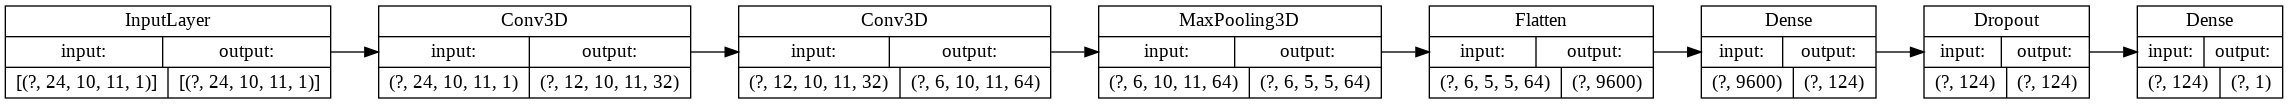

In [ ]:
keras.utils.plot_model( # Show model architecture
    modelB,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=False,
    rankdir='LR', # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
    dpi=96
)

In [ ]:
modelB.compile(loss='binary_crossentropy', 
               optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9), 
               metrics=['accuracy'])

In [ ]:
class_weight = {0: 1.,
                1: 5.}

In [ ]:
historyB = modelB.fit(epochs_B_TRAIN_reshaped, target_B_TRAIN, epochs=15, batch_size=32, class_weight=class_weight,
                    validation_data =(epochs_B_TEST_reshaped,target_B_TEST))

Train on 15300 samples, validate on 18000 samples
Epoch 1/15
15300/15300 [==============================] - 6s 411us/sample - loss: 1.6941 - acc: 0.5897 - val_loss: 0.8816 - val_acc: 0.4657
Epoch 2/15
15300/15300 [==============================] - 5s 324us/sample - loss: 1.1882 - acc: 0.6439 - val_loss: 0.8639 - val_acc: 0.5424
Epoch 3/15
15300/15300 [==============================] - 5s 326us/sample - loss: 1.1627 - acc: 0.6703 - val_loss: 0.8013 - val_acc: 0.6079
Epoch 4/15
15300/15300 [==============================] - 5s 324us/sample - loss: 1.1490 - acc: 0.6784 - val_loss: 0.8091 - val_acc: 0.5882
Epoch 5/15
15300/15300 [==============================] - 5s 323us/sample - loss: 1.1299 - acc: 0.6834 - val_loss: 0.8616 - val_acc: 0.5456
Epoch 6/15
15300/15300 [==============================] - 5s 323us/sample - loss: 1.1222 - acc: 0.6852 - val_loss: 0.5604 - val_acc: 0.8384
Epoch 7/15
15300/15300 [==============================] - 5s 325us/sample - loss: 1.1169 - acc: 0.6898 - val_l

In [ ]:
'''
# Save Model
modelA.save(os.path.join('drive/My Drive/Data','modelA.h5'))
modelB.save(os.path.join('drive/My Drive/Data','modelB.h5'))
'''

"\n# Save Model\nmodelA.save(os.path.join('drive/My Drive/Data','modelA.h5'))\nmodelB.save(os.path.join('drive/My Drive/Data','modelB.h5'))\n"

Put in line 4 and 5 the path for the folder that contains the models provided attached to the code

In [ ]:
'''
# Load Model
from tensorflow import keras

modelA = keras.models.load_model(os.path.join('drive/My Drive/Data','modelA.h5'))
modelB = keras.models.load_model(os.path.join('drive/My Drive/Data','modelB.h5'))
'''

"\n# Load Model\nfrom tensorflow import keras\n\nmodelA = keras.models.load_model(os.path.join('drive/My Drive/Data','modelA.h5'))\nmodelB = keras.models.load_model(os.path.join('drive/My Drive/Data','modelB.h5'))\n"

#**Subtask 3**

##CNN model results on test sets 

We define **binary_pred** function to convert the output of the network expressed in term of probability into an array of 0 and 1, putting the threshold at 0.5

In [ ]:
def binary_pred(predictions,tv):

  binary_predictions=np.zeros(len(predictions))
  for i in range(len(predictions)):
    if predictions[i] < tv:
      binary_predictions[i] = 0
    else:
      binary_predictions[i] = 1

  return binary_predictions
 

We define **stat** function to compute sensitivity, specificity, accuracy, PPV, NPV of our predictions

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import math


def stat (target_test, predictions, letter):
  cm = confusion_matrix(target_test, predictions)
  TN = cm[0,0]
  FP = cm[0,1]
  FN = cm[1,0]
  TP = cm[1,1]
  P = TP + FN
  N = TN + FP

  # sensitivity = TP / (TP + FN)
  sensitivity = recall_score(target_test, predictions)
  print ('sensitivity on test',letter,':\n',sensitivity)

  specificity = TN / (TN + FP)
  print ('specificity on test:',letter,':\n',specificity)

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  print ('accuracy on test:',letter,':\n',accuracy)

  # PPV = TP / (TP + FP)
  PPV = precision_score(target_test, predictions)
  print ('PPV on test',letter,':\n',PPV)

  NPV = TN / (TN + FN)
  print ('NPV on test',letter,':\n',NPV)

We applied the defined function to the modelA predictions

In [ ]:
# SUBJECT A:
predictions_A = modelA.predict(epochs_A_TEST_reshaped)
binary_predictions_A = binary_pred(predictions_A, 0.5)
stat(target_A_TEST, binary_predictions_A,'A')

sensitivity on test A :
 0.426
specificity on test: A :
 0.8455333333333334
accuracy on test: A :
 0.7756111111111111
PPV on test A :
 0.3554937413073713
NPV on test A :
 0.8804581742450538


We applied the defined function to the modelB predictions

In [ ]:
# SUBJECT B:
predictions_B = modelB.predict(epochs_B_TEST_reshaped)
binary_predictions_B = binary_pred(predictions_B, 0.5)
stat (target_B_TEST, binary_predictions_B,'B')

sensitivity on test B :
 0.306
specificity on test: B :
 0.9432666666666667
accuracy on test: B :
 0.8370555555555556
PPV on test B :
 0.5189372526851328
NPV on test B :
 0.8717269422709629


# **Subtask 4**

We define **letter2index** function that is fed with the letter and returns as output its coding in terms of row and column

In [ ]:
def letter2index(word):

  i = np.where(temp_MA==(word))[0][0] + 7
  j = np.where(temp_MA==(word))[1][0] + 1
  
  return i,j

We define **preSpeller** function, that prepare the data to be fed into the acutal Speller: in particular we extract epochs from stimulusCode exploiting information about the signal and if needed we properly format the target word

In [ ]:
def preSpeller(stimulusCode, word_TEST):

  if len(word_TEST[0]) > 1:
    word_TEST = list(word_TEST[0]) # Format the target word
  epochs = stimCode_reduced(stimulusCode) # Extract epochs from stimulusCode exploiting information about the signal

  return epochs, word_TEST

# Apply the function 
epochsA , word_A = preSpeller(stimulusCode_A, word_A_TEST)
epochsB, word_B = preSpeller(stimulusCode_B, word_B_TEST)

We define **code2letter** function that is fed with the number of the enhanced row/column and returns as output the letter

In [ ]:
def code2letter(l,k):
  
  temp=[l,k]
  temp.sort()
  l=temp[0]
  k=temp[1]
 
  MA=[['A','B','C','D','E','F'],
    ['G','H','I','J','K','L'],
    ['M','N','O','P','Q','R'],
    ['S','T','U','V','W','X'],
    ['Y','Z','1','2','3','4'],
    ['5','6','7','8','9','_']]
  
  i=k-7
  j=l-1
 
  letter=MA[i][j]
  return letter

We define **speller** function, that is fed with the output of the network,the rearranged StimulusCode data and the target word and it returns the predicted word and the accuracy of classification of the network at both letter and rows/columns resolution 

In [ ]:
def speller(predictions, stim_code, word, repetitions=15, verbose=True):

  protocol = 12 # The protocol expects a single letter acquisition is made of 12 intensifications
  y_pred = np.reshape(predictions, (-1,180)) # Reshape 1D array into a 100x180 matrix
  prediction = np.zeros((len(word),protocol)) # Size number_letter-by-12 (100x12) - It will store the cumsum of predictions corresponding to increasing number of repetitions over time for all the letters in dataset
  accuracy = np.zeros(repetitions) # 15 for the 15 repetitions
  accuracy_let = np.zeros(repetitions) # 15 for the 15 repetitions

  for rep in range (0,repetitions*protocol, protocol): # Repeat 15 times with step of 12 samples
    store_let = 0 # Temporary dummy variable to store the number of correct letter classification in one repetition
    store=0 # Temporary dummy variable to store the number of correct classification (P300 or not) in one repetition
    final_word = []

    for let in range(y_pred.shape[0]): # looping in whole dataset letters # range(5):
      temp_pred = y_pred[let, rep : rep + 12] # extract a single repetion for a single letter
      stim_code_temp = stim_code[let, rep : rep + 12].astype('int32') # extract the corresponding stimulus code for the extracted repetition
      prediction[let] += temp_pred[stim_code_temp.argsort()] # Sort the prediction according to its stimulus code, so I end up with an array in which at the first place I have
      # the cumulative probability to find a P300 at the given point of the session, taking into account all the past repetitions
      # stim_code_temp.argsort() gives me the indeces that i need to order my stimulus code inside the repetition in order to have [1,2,3,4,5,6,7,8,9,10,11,12]
      i = np.argmax(prediction[let,6:12]) + 7 # From 7 to 12 we have the rows
      j = np.argmax(prediction[let,0:6]) + 1 # From 1 to 6 we have the colums
      target_letter = code2letter(i,j) # Find correspondant letter
      final_word.append(target_letter) # POSSIBLE ERROR HERE IN THE BRACKETS # Put the letter into the result
      if word[let] == target_letter:
        store_let += 1
      i_temp, j_temp = letter2index(word[let]) # Getting the stimulus code for the letter I'm considering
      if i == i_temp: # Check if the stimulus code is the same for rows
        store += 1 # Then I properly classify my epoch
      if j == j_temp: # Check if the stimulus code is the same for rows
        store +=1 # Then I properly classify my epoch
  
  # Compute accuracy with a resolution of rows-and-columns and of letters
    accuracy[int(rep/protocol)] = store / (len(word)*2) # I divided by len(word)*2 because for each letter I need to classify properly one row and one column
    accuracy_let[int(rep/protocol)] = store_let / len(word)

# Print results
  if verbose:
    print("**********************************")
    print("          RESULTS          ")
    print("**********************************")
    print("Number of repetitions: %d" % repetitions)
    print("Accuracy of rows and columns classification: " + str(accuracy))
    print("Accuracy of letters classification: " + str(accuracy_let))
    print("final word: ", str(final_word))
    print("real word: ", str(word))
    print()
  
  return final_word, accuracy, accuracy_let

In the following cells, we compute the predicted word for subject A and B using 15 and 5 repetitions

In [ ]:
target_word_A,accuracy_A,accuracy_let_A = speller(predictions_A, epochsA, word_A)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.325 0.465 0.515 0.605 0.63  0.73  0.77  0.795 0.83  0.835 0.865 0.88
 0.88  0.9   0.91 ]
Accuracy of letters classification: [0.08 0.23 0.29 0.41 0.42 0.55 0.62 0.64 0.69 0.71 0.77 0.79 0.77 0.82
 0.84]
final word:  ['W', 'Q', 'X', 'P', 'L', 'Z', 'C', 'O', 'M', 'R', 'W', 'O', '9', '7', 'Y', 'F', 'Z', 'D', 'E', 'Z', '1', 'D', 'Q', 'A', '9', 'N', 'N', 'V', 'G', 'R', '8', 'D', 'K', 'C', 'U', 'V', 'R', 'M', 'E', 'U', 'O', 'O', 'O', 'J', 'D', '2', 'T', 'F', 'Y', 'P', 'O', 'O', '5', 'J', '7', 'L', 'D', 'G', 'Y', 'E', 'G', 'O', 'A', '5', 'V', 'T', 'N', 'E', 'L', 'B', 'T', '_', 'O', 'O', '1', 'T', 'D', 'O', 'I', 'L', 'U', 'E', 'E', '5', 'N', 'A', 'A', 'F', 'E', 'X', 'A', 'E', '_', 'K', '3', 'R', 'Y', 'M', 'R', 'U']
real word:  ['W', 'Q', 'X', 'P', 'L', 'Z', 'C', 'O', 'M', 'R', 'K', 'O', '9', '7', 'Y', 'F', 'Z', 'D', 'E', 'Z'

In [ ]:
target_word_A_5,_,_ = speller(predictions_A, epochsA, word_A, repetitions=5)

**********************************
          RESULTS          
**********************************
Number of repetitions: 5
Accuracy of rows and columns classification: [0.325 0.465 0.515 0.605 0.63 ]
Accuracy of letters classification: [0.08 0.23 0.29 0.41 0.42]
final word:  ['W', 'Q', 'K', '7', 'L', 'Z', 'E', 'O', 'G', '7', 'W', 'O', 'Q', '_', '4', 'F', 'S', 'A', 'E', 'Z', 'O', 'D', 'J', 'F', '9', 'Y', 'H', 'T', 'G', 'R', '8', 'D', 'E', 'C', '7', 'J', 'N', 'A', '9', 'U', 'O', 'U', '7', 'H', 'D', '8', 'N', 'F', 'M', '2', 'O', 'P', '2', 'H', '7', 'L', 'D', 'M', 'Y', 'E', 'G', 'T', 'G', '8', 'V', 'W', 'N', 'K', '5', 'B', 'Z', 'Y', 'O', 'O', '1', 'N', 'E', 'N', 'L', 'L', 'U', 'E', 'D', 'A', '6', 'M', 'A', 'R', 'E', 'W', 'A', 'W', '_', 'H', '2', 'Q', 'Y', 'M', 'P', 'U']
real word:  ['W', 'Q', 'X', 'P', 'L', 'Z', 'C', 'O', 'M', 'R', 'K', 'O', '9', '7', 'Y', 'F', 'Z', 'D', 'E', 'Z', '1', 'D', 'P', 'I', '9', 'N', 'N', 'V', 'G', 'R', 'Q', 'D', 'J', 'C', 'U', 'V', 'R', 'M', 'E', 'U', 'O', 'O', 

In [ ]:
target_word_B,accuracy_B,accuracy_let_B = speller(predictions_B, epochsB, word_B)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.435 0.625 0.68  0.745 0.785 0.82  0.855 0.865 0.87  0.905 0.885 0.93
 0.955 0.94  0.945]
Accuracy of letters classification: [0.17 0.39 0.52 0.56 0.61 0.69 0.74 0.77 0.78 0.84 0.78 0.88 0.92 0.9
 0.9 ]
final word:  ['M', 'E', 'R', 'M', 'I', 'O', 'O', 'O', 'M', 'U', 'Z', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', '_', 'C', 'O', 'R', 'Z', 'P', '3', 'G', 'L', 'O', 'O', '7', 'M', 'U', 'F', 'D', 'J', 'E', 'F', 'T', 'W', 'E', 'M', 'O', 'A', 'L', 'Z', 'O', 'P', '9', 'R', 'O', 'C', 'G', 'Z', 'E', 'S', '1', 'Y', '1', '9', 'E', 'W', 'X', '6', '5', 'Q', 'U', 'K', 'U', '7', 'N', 'A', 'K', '_', '4', 'S', 'C', 'J', 'D', 'V', 'D', 'N', 'G', 'Q', 'X', 'O', 'D', 'B', 'E', 'V', '2', 'B', '5', 'E', 'F', 'D', 'I', 'D', 'N', 'R']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L',

In [ ]:
target_word_B_5,_,_ = speller(predictions_B, epochsB, word_B, repetitions=5)

**********************************
          RESULTS          
**********************************
Number of repetitions: 5
Accuracy of rows and columns classification: [0.435 0.625 0.68  0.745 0.785]
Accuracy of letters classification: [0.17 0.39 0.52 0.56 0.61]
final word:  ['A', 'C', 'R', 'M', 'I', 'M', 'O', 'O', 'S', 'U', 'Z', 'J', 'O', 'L', 'J', 'O', 'H', 'U', 'V', 'X', 'B', 'O', 'R', 'T', 'Q', '2', 'A', 'L', 'O', 'O', 'I', 'A', 'S', 'F', 'C', 'K', 'F', 'F', 'T', 'V', 'B', 'O', 'O', 'A', 'F', '1', 'O', 'O', '9', 'Q', 'Z', 'C', 'G', 'Z', 'E', '6', '1', 'Y', 'Z', '9', 'E', 'W', 'T', '6', '5', 'Q', 'U', 'G', 'U', '7', 'N', 'A', 'D', '8', '4', '5', 'C', 'P', 'A', 'V', 'D', 'N', 'D', 'K', 'X', 'O', 'W', 'B', 'D', 'V', '2', 'B', '5', 'E', 'F', 'D', 'I', 'B', 'T', 'R']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L', 'E', 'O', 'R', 'Z', 'P', '3', 'G', 'L', 'O', 'O', '7', 'A', 'U', 'F', 'D', 'K', 'E', 'F', 'T', 'W', 'E', 'O', 

The aim of this cell is to save the resulting arrays of predicted letters in matlab format, as specified by the goal specifications

In [ ]:
'''
data = {'SA15': ''.join([str(item) for item in target_word_A]), 
        'SB15': ''.join([str(item) for item in target_word_B]), 
        'SA5': ''.join([str(item) for item in target_word_A_5]), 
        'SB5': ''.join([str(item) for item in target_word_B_5])
        }
savemat('results.mat', data)

# Download the matlab file containing results
from google.colab import files
files.download('./results.mat')
'''

"\ndata = {'SA15': ''.join([str(item) for item in target_word_A]), \n        'SB15': ''.join([str(item) for item in target_word_B]), \n        'SA5': ''.join([str(item) for item in target_word_A_5]), \n        'SB5': ''.join([str(item) for item in target_word_B_5])\n        }\nsavemat('results.mat', data)\n\n# Download the matlab file containing results\nfrom google.colab import files\nfiles.download('./results.mat')\n"

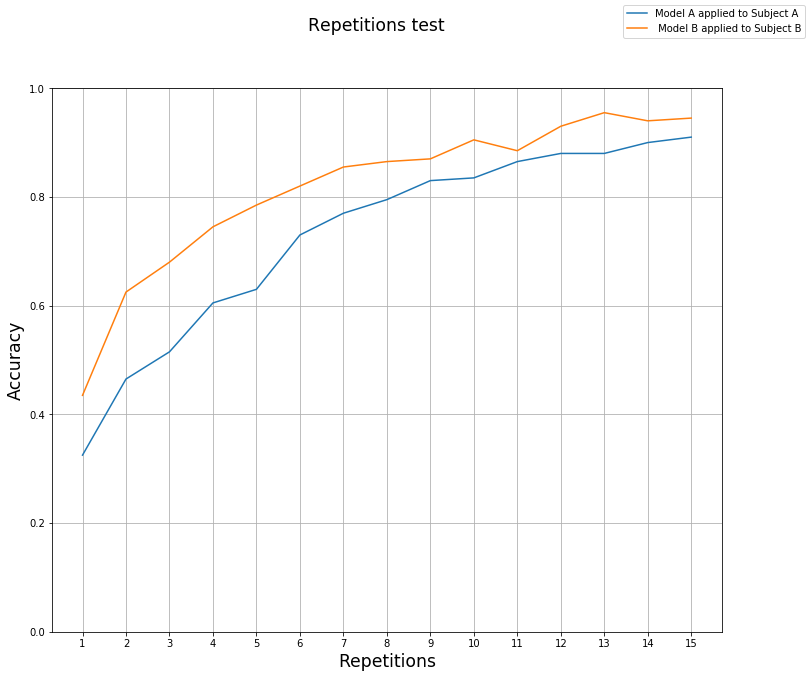

MessageError: ignored

In [ ]:
t = range(1,16)
fig = plt.figure(figsize=(12,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.plot(t, accuracy_A, t, accuracy_B)
plt.xlabel('Repetitions', size='xx-large')
plt.xticks(t)
plt.ylabel('Accuracy', size='xx-large')
fig.suptitle('Repetitions test', size='xx-large')
fig.legend(['Model A applied to Subject A',' Model B applied to Subject B'])
plt.show()

fig.savefig('accuracy.png')
files.download('accuracy.png')

#**Subtask 5**

##Network trained on subject A to predict the EEG epochs of subject B

We obtain the results in terms of classification performance when using the network trained on subject A to predict the EEG epochs of subject B

In [ ]:
predictions_B_on_A = modelB.predict(epochs_A_TEST_reshaped)
binary_predictions_B_on_A = binary_pred(predictions_B_on_A, 0.5)
stat(target_B_TEST, binary_predictions_B_on_A,'B on A')

sensitivity on test B on A :
 0.07466666666666667
specificity on test: B on A :
 0.9267333333333333
accuracy on test: B on A :
 0.7847222222222222
PPV on test B on A :
 0.1693121693121693
NPV on test B on A :
 0.8335432032140073


Then, we obtain the results also in term of accuracy in letter prediction again by using the network trained on A to predict letters of subject B

In [ ]:
_,accuracy_BA,_ = speller(predictions_B_on_A, epochsB, word_B)

**********************************
          RESULTS          
**********************************
Number of repetitions: 15
Accuracy of rows and columns classification: [0.17  0.155 0.18  0.16  0.165 0.17  0.16  0.185 0.175 0.17  0.165 0.155
 0.16  0.16  0.17 ]
Accuracy of letters classification: [0.01 0.01 0.05 0.04 0.01 0.01 0.01 0.04 0.   0.02 0.01 0.02 0.05 0.03
 0.03]
final word:  ['Z', 'C', '6', 'C', 'G', '3', 'K', 'E', '1', 'C', 'G', 'L', '5', 'D', 'X', '2', '4', 'Q', '4', 'X', 'Q', 'G', 'Y', 'G', 'K', 'A', 'E', 'D', 'X', '6', '9', '7', 'H', '9', 'F', 'X', 'W', 'Z', 'C', '3', '7', '4', 'D', '4', 'C', 'T', '6', 'K', 'P', 'R', 'Z', 'X', 'A', '6', 'K', 'N', '5', 'K', 'G', 'Q', '6', 'R', 'O', 'A', 'T', 'L', 'S', '3', 'V', 'M', '9', 'U', 'G', '7', '4', 'N', '4', 'U', 'A', 'X', '9', '8', '8', 'V', 'N', '8', '5', 'J', 'T', '7', 'J', 'H', 'J', 'X', 'F', 'N', 'V', '8', 'M', 'B']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O', 'H', 'U', 'V', 'L

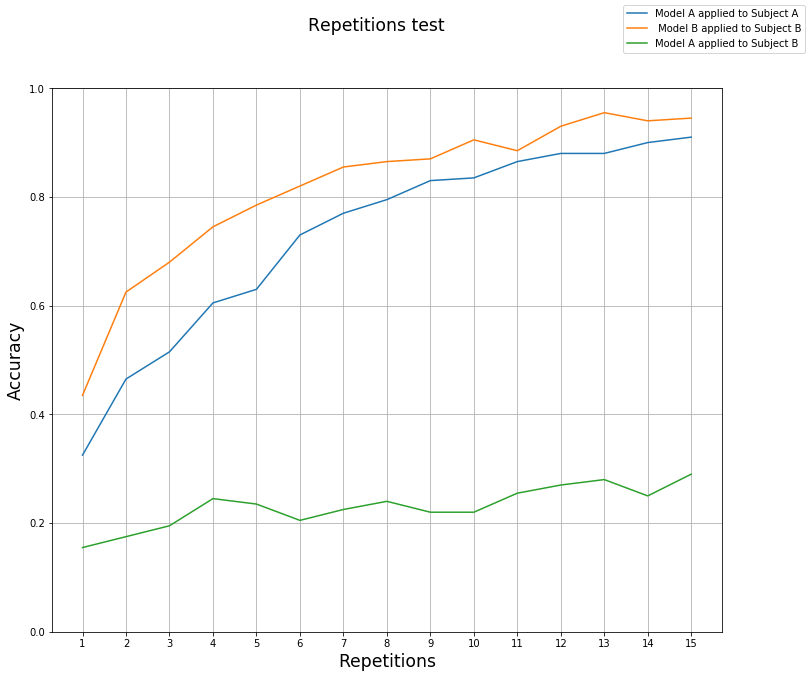

In [ ]:
t = range(1,16)
fig = plt.figure(figsize=(12,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.plot(t, accuracy_A, t, accuracy_B, t, accuracy_BA)
plt.xlabel('Repetitions', size='xx-large')
plt.xticks(t)
plt.ylabel('Accuracy', size='xx-large')
fig.suptitle('Repetitions test', size='xx-large')
fig.legend(['Model A applied to Subject A',' Model B applied to Subject B', 'Model A applied to Subject B'])
plt.show()

fig.savefig('accuracy_total.png')
files.download('accuracy_total.png')

## Network trained on both subjects A and B

To analyze the	performance	of	the	network	when	trained	on	data	of	both	subjects, we combine the two dataset

In [ ]:
flag = True

In [ ]:
'''
if flag:
  epochs_B_TRAIN_noP300 = matrixchannel(epochs_B_TRAIN_noP300)
  epochs_B_TRAIN_P300 = matrixchannel(epochs_B_TRAIN_P300)
  flag = False

a = np.random.randint(0,12750,size=2550)
b = np.random.randint(0,12750,size=2550)
epochs_A_TRAIN_noP300a = epochs_A_TRAIN_noP300[a] # balancing the datasets after shuffling the data (truncating the extra data)
epochs_B_TRAIN_noP300b = matrixchannel(epochs_B_TRAIN_noP300[b] # balancing the datasets after shuffling the data (truncating the extra data)
epochs_A_TRAINa = np.concatenate((epochs_A_TRAIN_noP300a, epochs_A_TRAIN_P300))
epochs_B_TRAINb = np.concatenate((epochs_B_TRAIN_noP300b, epochs_B_TRAIN_P300))
'''

In [ ]:
'''
epochs_AB_TRAIN_reshaped=np.concatenate((epochs_A_TRAINa[:len(epochs_A_TRAINa)//2],epochs_B_TRAINb[:len(epochs_B_TRAINb)//2]))
epochs_AB_TEST_reshaped=np.concatenate((epochs_A_TEST_reshaped[a],epochs_B_TEST_reshaped[b]))
target_AB_TRAIN=np.concatenate((target_A_TRAIN[a],target_B_TRAIN[b]))
target_AB_TEST=np.concatenate((target_A_TEST[a],target_B_TEST[b]))
stimulusCode_AB=np.concatenate((stimulusCode_A,stimulusCode_B))
word_AB=word_A+word_B
#epochs_AB_TRAIN_reshaped = np.expand_dims(epochs_AB_TRAIN_reshaped, axis=4)
'''

In [ ]:
#epochs_AB_TRAIN_reshaped = np.expand_dims(epochs_AB_TRAIN_reshaped, axis=4)

In [ ]:
epochs_AB_TRAIN_reshaped=np.concatenate((epochs_A_TRAIN_reshaped,epochs_B_TRAIN_reshaped))
epochs_AB_TEST_reshaped=np.concatenate((epochs_A_TEST_reshaped,epochs_B_TEST_reshaped))
target_AB_TRAIN=np.concatenate((target_A_TRAIN,target_B_TRAIN))
target_AB_TEST=np.concatenate((target_A_TEST,target_B_TEST))
stimulusCode_AB=np.concatenate((stimulusCode_A,stimulusCode_B))

We create the model again in order to train it on both subject

In [ ]:
# MODEL AB
from tensorflow import keras
from keras import backend as K
import tensorflow as tf

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


modelAB = keras.models.Sequential([
        keras.layers.Conv3D(filters=32, input_shape=[24, 10, 11, 1], kernel_size = [3,2,2], strides=(2,1,1),activation = 'elu', padding="SAME", 
                            kernel_regularizer= keras.regularizers.l2(l=0.02)),
                            
        keras.layers.Conv3D(filters=64, kernel_size = [2,2,2], strides=(2,1,1),activation = 'elu', padding="SAME",
                            kernel_regularizer= keras.regularizers.l2(l=0.02)),

        keras.layers.MaxPool3D(pool_size=(1,3,3)),
        keras.layers.BatchNormalization(), # normalizing the batch

        keras.layers.Flatten(),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(units=124, activation='elu', kernel_regularizer= keras.regularizers.l2(l=0.02)),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(units=1, activation='softmax')                                 
])

We compile modelAB

In [ ]:
modelAB.compile(loss='binary_crossentropy', 
               optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9),
               #optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
               metrics=['accuracy'])

In [ ]:
class_weight = {0: 1.,
                1: 1.}

Then, we fit the model on the combined dataset AB

In [ ]:
historyAB = modelAB.fit(epochs_AB_TRAIN_reshaped, target_AB_TRAIN, epochs=10, batch_size=32, class_weight = class_weight,
                    validation_data =(epochs_AB_TEST_reshaped,target_AB_TEST))

Train on 30600 samples, validate on 36000 samples
Epoch 1/10
30600/30600 [==============================] - 15s 479us/sample - loss: 12.7800 - acc: 0.1667 - val_loss: 12.7100 - val_acc: 0.1667
Epoch 2/10
30600/30600 [==============================] - 12s 386us/sample - loss: 12.7800 - acc: 0.1667 - val_loss: 12.7100 - val_acc: 0.1667
Epoch 3/10
23840/30600 [======================>.......] - ETA: 1s - loss: 12.7660 - acc: 0.1676

KeyboardInterrupt: ignored

Analyze the performance of the network when trained on data of both subjects

In [ ]:
# extract epochs from stimulusCode_AB exploiting information about the signal
epochsAB , word = preSpeller(stimulusCode_AB, word_AB)

# obtain prediction for modelA trained by data of both subject
predictions_AB = modelAB.predict(epochs_AB_TEST_reshaped)

# evaluate classification performance
binary_predictions_AB = binary_pred(predictions_AB, 0.5)
stat(target_AB_TEST, binary_predictions_AB,'AB')

sensitivity on test AB :
 0.5415
specificity on test: AB :
 0.6926
accuracy on test: AB :
 0.6674166666666667
PPV on test AB :
 0.2605244166466202
NPV on test AB :
 0.8830804539079434


In conclusion, we obtain the results also in term of accuracy in letter prediction, again by using the network trained on A and on B

In [ ]:
# apply the speller fun on predictionsAB
target_word_AB,accuracy_AB,accuracy_let_AB = speller(predictions_AB, epochsAB, word_AB)

In [ ]:
t = range(1,16)
fig = plt.figure(figsize=(12,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.plot(t, accuracy_let_A, t, accuracy_let_B, t, accuracy_let_AB)
plt.xlabel('Repetitions', size='xx-large')
plt.xticks(t)
plt.ylabel('Accuracy', size='xx-large')
fig.suptitle('Repetitions test', size='xx-large')
fig.legend(['Model A applied to Subject A','Model B applied to Subject B','Model AB applied to Subjects A and B'])
plt.show()